In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [19]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    
    
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1, groups=None):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y,groups)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

In [3]:
X = pd.read_pickle("X.pkl")
y = pd.read_pickle("y.pkl")
X_test = pd.read_pickle("X_test.pkl")
test = pd.read_pickle("test.pkl")


In [4]:
for col in (set(X.columns) - set(X_test.columns)):
    X_test[col] = 0

In [5]:
for col in (set(X_test.columns) - set(X.columns)):
    X[col] = 0

In [14]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,R_emaildomain_bin,R_emaildomain_suffix,TransactionAmt_to_mean_card_id,TransactionAmt_to_std_card_id,dist1_to_mean_card_id,dist1_to_std_card_id,dist2_to_mean_card_id,dist2_to_std_card_id,_Hours_to_mean_card_id,_Hours_to_std_card_id
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4,4248,-128,50,1,42,1,215,80,...,-128,-12,0.265625000000,0.324951171875,2.279296875,2.056640625,NaN,NaN,0.0,0.0
2987001,29.0,4,9979,304,50,2,2,1,225,80,...,-128,-12,0.135742187500,0.000000000000,NaN,NaN,NaN,NaN,0.0,0.0
2987002,59.0,4,11850,390,50,3,66,2,230,80,...,-128,-12,0.562988281250,0.452636718750,3.308593750,0.000000000,NaN,NaN,0.0,0.0
2987003,50.0,4,8796,467,50,2,17,2,376,80,...,-128,-12,0.413330078125,0.254150390625,NaN,NaN,NaN,NaN,0.0,0.0
2987004,50.0,1,11687,414,50,2,2,1,320,80,...,-128,-12,0.500976562500,0.716308593750,NaN,NaN,NaN,NaN,0.0,0.0


In [6]:
# col = ['DeviceInfo_FraudRate', 'card1_FraudRate']
# #X.drop(col, axis=1,inplace=True)
# X_test.drop(col, axis=1,inplace=True)
# test.drop(col, axis=1,inplace=True)

In [17]:
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
# folds = KFold(n_splits=5)
folds = GroupKFold(n_splits=5)
groups = pd.read_pickle('./groups.pkl').values

array([8398,  138,  100, ...,  135,   30,    4], dtype=int64)

In [10]:
numerical_cols = ['V197', 'V332', 'V33', 'V31', 'V246', 'V314', 'V75', 'V171', 'V211', 'V267', 'V324', 'V91', 'V23', 'V39', 'V68', 'V79', 'V291', 'V317', 'D14', 'C7', 'id_02', 'V224', 'V272', 'V281', 'V277', 'V172', 'V184', 'V311', 'V213', 'V225', 'V144', 'V120', 'V304', 'C1', 'V37', 'V80', 'V216', 'V2', 'V132', 'V53', 'V328', 'V145', 'V133', 'P_emaildomain', 'V126', 'V282', 'V270', 'C11', 'V285', 'V244', 'V269', 'dist2_to_std_card_id', 'V16', 'V100', 'V104', 'V199', 'id_10', 'V124', 'V154', 'V128', 'V206', 'V29', 'V228', 'V265', 'V247', 'V42', 'V212', 'id_09', 'V97', 'Date', 'V81', 'V71', 'V257', 'V84', 'V284', 'V319', 'V320', 'D13', 'V185', 'V266', 'C13', 'dist1_to_std_card_id', 'V195', 'V1', 'TransactionAmt', 'V253', 'V209', 'V223', 'V301', 'V176', 'V221', 'V7', 'V74', 'dist2_to_mean_card_id', 'V155', 'V114', 'V290', 'V240', 'V300', 'V4', 'TransactionAmt_to_std_card_id', 'V294', 'V69', 'V118', 'D15', 'V208', 'R_emaildomain', 'V66', 'V239', 'isFraud', 'V103', 'V234', '_Days', 'V275', 'V106', 'V111', 'V143', 'V238', 'V35', 'V83', 'V19', 'V283', 'V236', 'card_id', 'V331', 'V47', 'V302', 'V123', 'V21', 'V125', 'C6', 'V179', 'V48', 'V46', 'V207', 'V200', 'V109', 'V175', 'V27', 'V72', 'V310', 'V117', 'V166', 'V177', 'C10', 'V308', 'V3', 'D11', 'V178', 'V264', 'V98', 'V256', 'V139', 'V20', 'V40', 'V92', 'V273', 'V305', 'V159', 'V105', 'V245', 'V251', 'V261', 'V315', 'D2', 'V241', 'V231', 'V325', 'id_08', 'V147', 'V254', 'V108', 'V25', 'V183', 'V161', 'C2', 'V222', 'V255', 'V293', 'V140', 'V162', 'V96', 'D4', 'V142', 'V82', 'V259', 'V54', 'V86', 'V287', 'V268', 'C12', 'V45', 'V252', 'V156', 'V198', 'V232', 'V336', 'V164', 'V220', 'NanIdentityCount', 'V210', 'D9', 'V51', 'V73', 'V77', 'V153', 'V219', 'V78', 'V158', 'V194', '_Hours_to_mean_card_id', 'V262', 'V193', 'V233', 'D12', 'V121', 'V258', 'V243', 'V298', 'TransactionAmt_to_mean_card_id', 'V214', 'V286', 'V329', 'V64', 'V227', 'V122', 'V187', 'V180', 'V249', 'V289', 'V18', 'V215', 'V61', 'V242', 'V58', 'V127', 'V279', 'V189', 'V181', 'NanTransactionCount', 'V38', 'V274', 'V70', 'V110', 'V299', 'V130', 'V235', 'V288', 'V129', 'V30', 'V205', 'D5', 'V11', 'V90', 'dist2', 'D7', 'V119', 'V296', 'V318', 'D1', 'V107', 'id_01', 'V173', 'V191', 'V169', '_Hours_to_std_card_id', 'V295', 'id_07', 'V321', 'V338', 'V330', 'V24', 'id_05', 'V94', 'V22', 'V335', 'V167', 'V115', 'V292', 'V99', 'V280', 'V230', 'V137', 'V13', 'V60', 'V43', 'C4', 'V260', 'V89', 'V88', 'V190', 'V326', 'V327', 'V59', 'id_06', 'V337', 'V148', 'V15', 'V34', 'V323', 'id_11', 'V182', 'V276', 'V160', 'V202', 'V63', 'V218', 'V165', 'V134', 'V93', 'V116', 'V203', 'V138', 'V149', 'V250', 'V204', 'V62', 'V201', 'V17', 'V170', 'V278', 'V217', 'V309', 'C8', 'V12', 'V313', 'V49', 'V229', 'V87', 'V26', 'C9', 'V174', '_Hours', 'V186', 'V8', 'D3', 'dist1_to_mean_card_id', 'V322', 'id_03', 'V226', 'V136', 'dist1', 'V85', 'V56', 'D10', 'C3', 'V192', 'V6', 'V113', 'D8', 'V303', 'V50', 'V168', 'V52', 'V76', 'V163', 'V333', 'V9', 'V36', 'V112', 'V271', 'V151', 'V237', 'V307', 'V150', 'V188', 'V196', 'C5', 'V306', 'V263', 'V141', 'V67', 'V152', 'V135', 'id_04', 'V334', 'V14', 'D6', 'C14', 'V131', 'V339', 'V44', 'V102', 'V5', 'V157', 'V248', 'V10', 'V32', 'V57', 'V101', 'V146', 'V316', 'V28', 'V65', 'V55', 'V297', 'V41', 'V312', 'V95', '_Weekdays']
label_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix', 'addr1', 'addr2', 'ProductCD', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']
# [label_cols.remove(i) for i in ['id_19', 'id_20', 'id_21', 'card2', 'id_33']]

In [11]:
categorical_features = [c for c, col in enumerate(X.columns) if col in label_cols]

In [12]:
categorical_features


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 436,
 437,
 438,
 439]

In [20]:
for col in label_cols:
    if  X_test[col].unique().size > 100:
        print(col, X_test[col].unique().size)

id_17 104
id_19 503
id_20 437
id_21 444
id_25 310
id_31 136
id_33 391
DeviceInfo 2218
addr1 293
card1 13244
card2 498
card3 116
card5 103


In [21]:
y = y.astype(np.bool)

Fold 1 started at Mon Aug  5 18:18:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[157]	training's auc: 0.989596	training's auc: 0.989596	valid_1's auc: 0.843258	valid_1's auc: 0.843258
Fold 2 started at Mon Aug  5 18:22:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[210]	training's auc: 0.992599	training's auc: 0.992599	valid_1's auc: 0.860242	valid_1's auc: 0.860242
Fold 3 started at Mon Aug  5 18:27:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[168]	training's auc: 0.989555	training's auc: 0.989555	valid_1's auc: 0.877899	valid_1's auc: 0.877899
Fold 4 started at Mon Aug  5 18:32:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's auc: 0.993431	training's auc: 0.993431	valid_1's auc: 0.884822	valid_1's auc: 0.884822
Fold 5 started at Mo

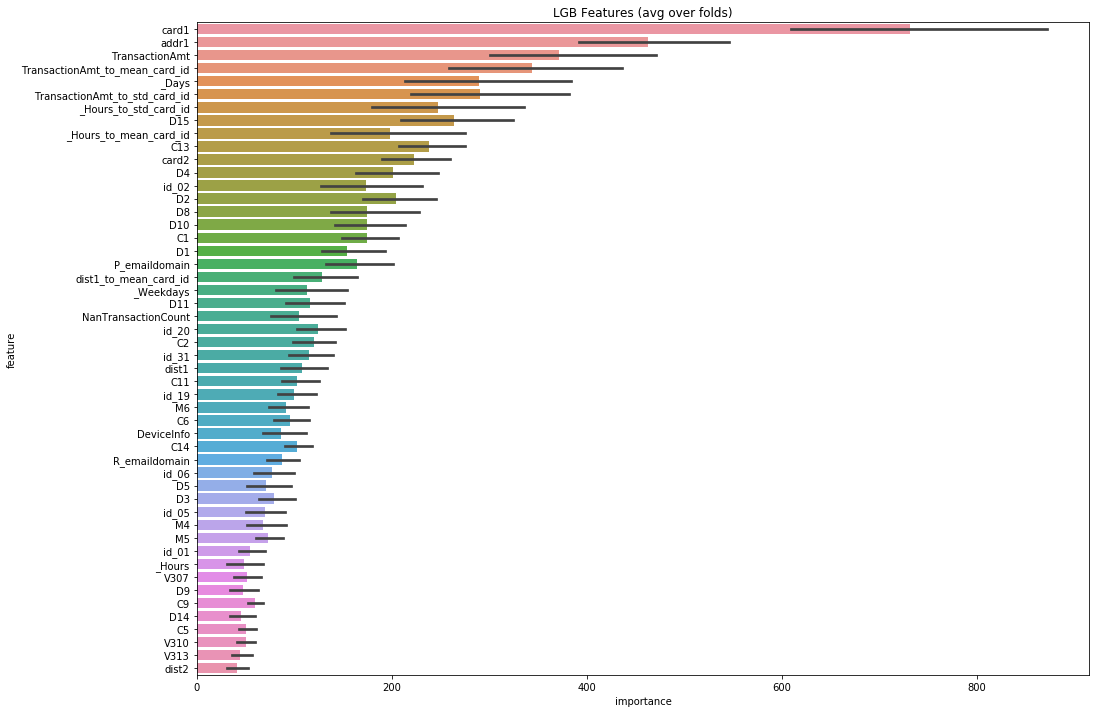

In [22]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'categorical_feature': categorical_features,
#           'device': 'gpu'
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1, groups=groups)

In [23]:
# cat_params = {'num_leaves': 256,
#           'min_child_samples': 79,
#           'objective': 'CrossEntropy',
#           'max_depth': 13,
#           'learning_rate': 0.03,
#           "boosting_type": "Ordered",
#           'reg_lambda': 0.3,
#           'task_type':'GPU'
#          }
# result_dict_cat = train_model_classification(X=X, X_test=X_test, y=y, params=cat_params, folds=folds, model_type='cat', eval_metric='auc', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [24]:
test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [25]:
result_dict_lgb['prediction']


array([[0.00160912],
       [0.00411625],
       [0.0027342 ],
       ...,
       [0.00974654],
       [0.0063955 ],
       [0.00623675]])

In [26]:
test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card_id,TransactionAmt_to_mean_card_id,TransactionAmt_to_std_card_id,dist1_to_mean_card_id,dist1_to_std_card_id,dist2_to_mean_card_id,dist2_to_std_card_id,_Hours_to_mean_card_id,_Hours_to_std_card_id,prediction
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,31.953125,4,442,11,50,3,126,2,70,80,...,844,0.28662109375,0.251708984375,0.008880615234375,0.005661010742188,NaN,NaN,0.0,0.0,0.001609122715212
3663550,49.000000,4,11471,11,50,3,126,2,199,80,...,86,0.31933593750,0.000000000000,0.035461425781250,0.000000000000000,NaN,NaN,0.0,0.0,0.004116245814390
3663551,171.000000,4,11668,474,50,3,126,2,372,80,...,1403,1.23339843750,1.261718750000,2.183593750000000,0.000000000000000,NaN,NaN,0.0,0.0,0.002734195883894
3663552,285.000000,4,1069,260,50,3,66,2,105,80,...,93,3.17382812500,2.183593750000,0.187744140625000,0.000000000000000,NaN,NaN,0.0,0.0,0.001028743902293
3663553,67.937500,4,8674,352,50,2,17,2,164,80,...,64,0.58740234375,0.316650390625,0.062225341796875,0.000000000000000,NaN,NaN,0.0,0.0,0.001843558008011


In [27]:
folder_path = './data/'
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('submission_7.csv', index=False)